In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [2]:
np.random.seed(42)

# Portfolio Planner

In this activity, you will use the Alpaca api to grab historical data for a 60/40 portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [3]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# api = tradeapi.REST()
api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [4]:
assets = api.list_assets()
tradeable = [asset for asset in assets if asset.tradable ]

# Create a new empty DataFrame
asset_info_df = pd.DataFrame()
asset_info_df['symbol'] = pd.Series([asset.symbol for asset in assets])

list_of_tickers = ["SPY", "AGG"]

# Set timeframe to '1D'
timeframe = '1D'

start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

# Get 30 year's worth of historical data
stock_prices = api.get_barset(
    list_of_tickers,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

stock_prices.drop(columns=['open', 'high', 'low', 'volume'], level=1, inplace=True)

stock_prices.to_csv("stock_prices.csv", index=True)
stock_prices.head()

,AGG,SPY
,close,close
time,,
2019-01-02 00:00:00-05:00,106.585,249.89
2019-01-03 00:00:00-05:00,107.020,244.46
2019-01-04 00:00:00-05:00,106.695,252.41
2019-01-07 00:00:00-05:00,106.470,254.40
2019-01-08 00:00:00-05:00,106.420,256.65


# Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:
1. Calculate the daily returns for the SPY and AGG closing prices.
2. Calculate volatility for both the SPY and AGG closing prices.
3. Find the last day's closing price for both stocks and save those as variables.
4. Run a Monte Carlo Simulation of at least 500 iterations and generate at least 30 years of closing prices

### HINTS:
There are 252 trading days per year, so the number of records to generate for each Monte Carlo run will be 252 days * 30 years

In [5]:
# Calculate the daily roi for the stocks
stock_returns = stock_prices.pct_change()
avg_daily_return_AGG = stock_returns.mean()['AGG']['close']
avg_daily_return_SPY = stock_returns.mean()['SPY']['close']
avg_daily_return_AGG

0.00021277231473764173

In [6]:
# Calculate volatility
std_dev_daily_return_AGG = stock_returns.std()['AGG']['close']
std_dev_daily_return_SPY = stock_returns.std()['SPY']['close']
std_dev_daily_return_AGG

0.002089826211646555

In [7]:
# Save the last day's closing price
SPY_last_price = stock_prices['SPY']['close'][-1]
AGG_last_price = stock_prices['AGG']['close'][-1]

In [8]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30
monte_carlo = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

In [9]:
# Run the Monte Carlo Simulation
for x in range(number_simulations):

    # Initialize the simulated prices list with the last closing price of `SPY` and `AGG`
    simulated_SPY_prices = [SPY_last_price]
    simulated_AGG_prices = [AGG_last_price]
    
    # Simulate the returns for 252 days
    for i in range(number_records):
        
        # Calculate the simulated price using the last price within the list
        simulated_SPY_price = simulated_SPY_prices[-1] * (1 + np.random.normal(avg_daily_return_SPY, std_dev_daily_return_SPY))
        simulated_AGG_price = simulated_AGG_prices[-1] * (1 + np.random.normal(avg_daily_return_AGG, std_dev_daily_return_AGG))
        
        # Append the simulated price to the list
        simulated_SPY_prices.append(simulated_SPY_price)
        simulated_AGG_prices.append(simulated_AGG_price)
    
    # Append a simulated prices of each simulation to DataFrame
    monte_carlo["SPY prices"] = pd.Series(simulated_SPY_prices)
    monte_carlo["AGG prices"] = pd.Series(simulated_AGG_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = monte_carlo.pct_change()
    
    # Set the portfolio weights (60% SPY; 40% AGG)
    weights = [0.60, 0.40]

    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[x] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

# Print records from the DataFrame
portfolio_cumulative_returns.head(10)

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.002924,0.995999,0.993589,0.999839,1.005673,1.006943,1.009401,0.996558,1.001958,0.999350,...,1.002269,0.995970,1.007308,1.000163,0.997898,1.003207,0.996441,0.994146,1.003209,0.997553
2,1.007960,0.999998,0.993068,0.999039,1.009071,0.998193,1.004123,0.986299,1.001346,1.007829,...,1.004518,1.003370,1.010545,1.001969,0.999475,1.000274,0.996136,0.994776,1.003311,1.001444
3,1.007370,1.000231,0.996724,0.993520,1.008617,1.001408,1.008137,0.980584,1.001321,1.016101,...,1.004743,1.006240,1.015344,1.003629,0.993173,0.999241,1.000000,1.000495,1.006827,1.000482
4,1.016195,1.003283,0.993397,0.999441,1.010295,0.996675,1.007118,0.978044,1.009298,1.006308,...,1.006802,1.004677,1.014131,1.008910,0.999443,0.996475,0.994644,1.001387,1.011503,1.004131
5,1.015138,1.001465,0.992443,1.005920,1.008996,0.991780,1.006493,0.981998,1.006680,1.007330,...,1.004882,1.001979,1.017069,1.009293,0.995941,0.995657,0.996705,1.000626,1.016112,1.004557
6,1.013256,0.999017,0.986374,1.008904,1.011469,0.994252,0.999817,0.984962,1.006995,1.006707,...,1.013751,1.000688,1.019076,1.014154,1.002371,0.993606,1.003549,0.990687,1.016074,1.001004
7,1.013504,0.996626,0.982702,1.010399,1.008359,0.993937,0.998529,0.981745,1.002769,1.003349,...,1.012810,1.005342,1.021909,1.025068,1.002319,0.993782,1.006754,0.992601,1.012075,0.997806
8,1.005544,1.000494,0.979078,1.006144,1.000191,0.989350,0.994595,0.988592,1.010191,1.001868,...,1.013721,1.005782,1.026569,1.023569,1.009403,0.999451,1.010204,0.992969,1.008623,1.007831
9,1.001743,0.999328,0.979906,1.006235,1.003384,0.984692,0.998086,0.989934,1.007799,1.002180,...,1.015723,1.003657,1.021169,1.025050,1.004725,1.000363,1.003270,0.991209,1.001516,1.017553


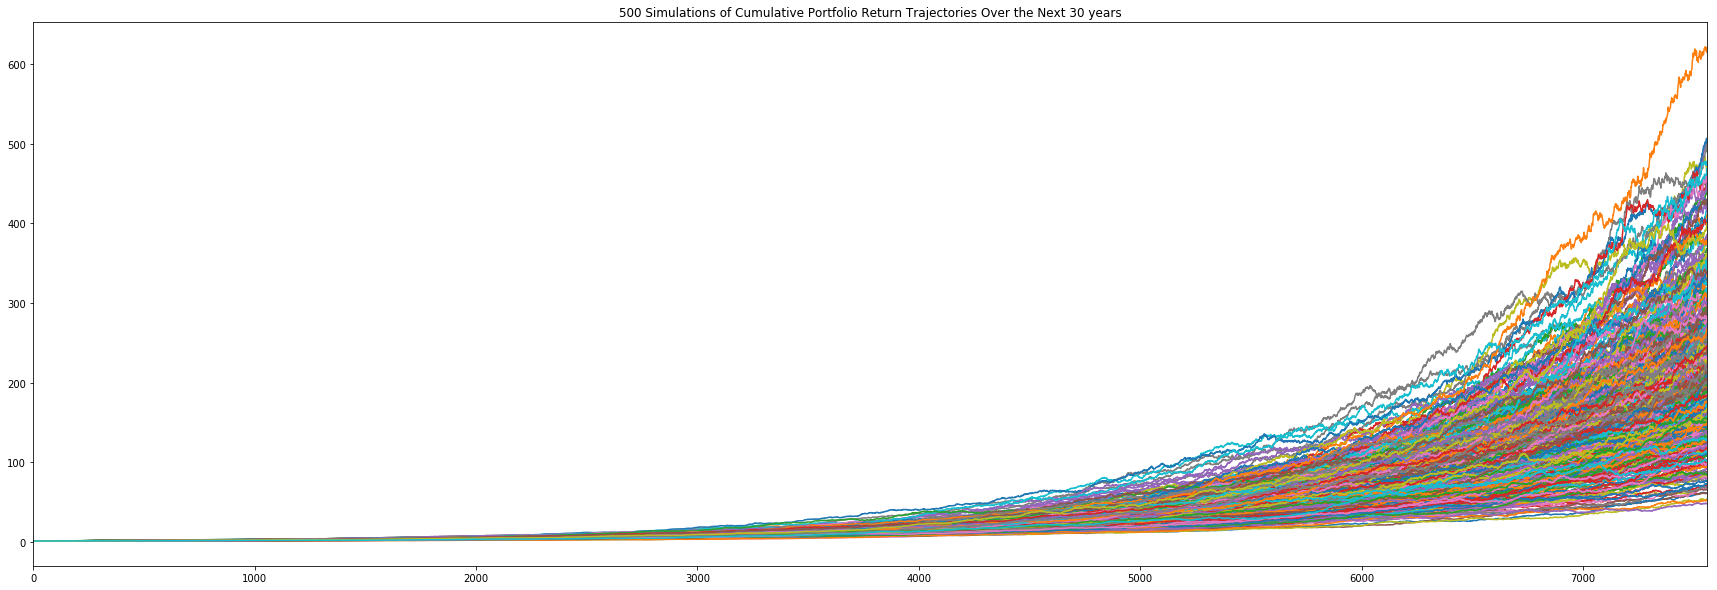

In [11]:
# Visualize the Simulation
plot_title = f"{x+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next 30 years"
portfolio_cumulative_returns.plot(legend=None, figsize=(30,10), title=plot_title)

In [10]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
ending_cumulative_returns_30 = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns_30.head()

0    224.965889
1    185.695782
2    254.090683
3    267.175574
4    242.897877
Name: 7560, dtype: float64

In [11]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
ending_cumulative_returns_20 = portfolio_cumulative_returns.iloc[-2520, :]
ending_cumulative_returns_20.head()

0    30.141531
1    33.034391
2    25.789741
3    36.375847
4    40.470604
Name: 5041, dtype: float64

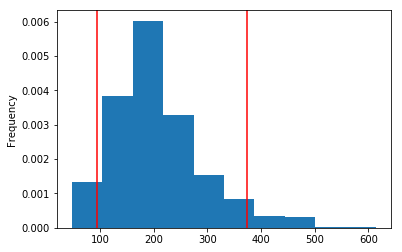

In [12]:
# Display the 90% confidence interval for the ending returns
confidence_interval = ending_cumulative_returns_30.quantile(q=[0.05, 0.95])
plt.figure();
ending_cumulative_returns_30.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

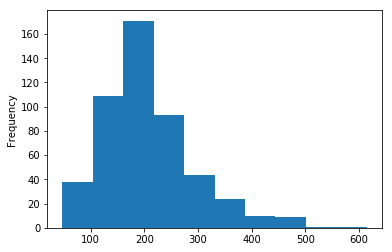

In [13]:
# Visualize the distribution of the ending returns
ending_cumulative_returns_30.plot(kind='hist', bins=10)

---

# Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?
2. Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?
3. Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?
4. How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [14]:
# YOUR CODE HERE
expected_cumulative_return_90th = np.percentile(ending_cumulative_returns_30, 90)
expected_cumulative_return_50th = np.percentile(ending_cumulative_returns_30, 50)
expected_cumulative_return_10th = np.percentile(ending_cumulative_returns_30, 10)
print("Expected cumulative return in 30 years for 10th percentile is $ {:0.2f}".format(expected_cumulative_return_10th))
print("Expected cumulative return in 30 years for 50th percentile is $ {:0.2f}".format(expected_cumulative_return_50th))
print("Expected cumulative return in 30 years for 90th percentile is $ {:0.2f}".format(expected_cumulative_return_90th))

Expected cumulative return in 30 years for 10th percentile is $ 117.38
Expected cumulative return in 30 years for 50th percentile is $ 189.84
Expected cumulative return in 30 years for 90th percentile is $ 314.35


### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [15]:
# YOUR CODE HERE
# Set initial investment
initial_investment = 20000

expected_return_10th = initial_investment * expected_cumulative_return_10th
expected_return_50th = initial_investment * expected_cumulative_return_50th
expected_return_90th = initial_investment * expected_cumulative_return_90th

print("Expected portfolio return in $ at 10th percentile is $ {:0.2f}".format(expected_return_10th))
print("Expected portfolio return in $ at 50th percentile is $ {:0.2f}".format(expected_return_50th))
print("Expected portfolio return in $ at 90th percentile is $ {:0.2f}".format(expected_return_90th))

Expected portfolio return in $ at 10th percentile is $ 2347518.91
Expected portfolio return in $ at 50th percentile is $ 3796876.65
Expected portfolio return in $ at 90th percentile is $ 6286947.21


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [21]:
# YOUR CODE HERE
projected_income = 7389
total = projected_income * 30
retirement_income = .04 * (initial_investment * portfolio_cumulative_returns.quantile(1)).iloc[0]

print("Projected income over 30 years is $ {:0.2f}".format(total))
print("Retirement portfolio with a 4% withdrawal rate in the 10th percentile is $ {:0.2f}".format(retirement_income))

Projected income over 30 years is $ 221670.00
Retirement portfolio with a 4% withdrawal rate in the 10th percentile is $ 181340.33


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [23]:
# YOUR CODE HERE
initial_investment_50 = 30000
retirement_income_50 = .04 * (initial_investment_50 * portfolio_cumulative_returns.quantile(1)).iloc[0]

print("A 50% increase in the initial investment with a 4% withdrawal rate will result in a retirement income of $ {:0.2f}".format(retirement_income_50))
print('The 4% retirment withdrawal will be higher but as a result, the retirement income will be higher than the projected income')

A 50% increase in the initial investment with a 4% withdrawal rate will result in a retirement income of $ 272010.50
The 4% retirment withdrawal will be higher but as a result, the retirement income will be higher than the projected income
